# Question Classification

We used Amazon QA dataset (https://cseweb.ucsd.edu/~jmcauley/datasets/amazon/qa/) to do this task. There are 2 type of question which are yes/no and open-ended. Furthermore, there are 21 type of product (21 json file)

## Experiment

We have trained 2 models (biLSTM and CNN) on different parameter with small (100 per product category) and large dataset (500 per product category). Moreover, we saved the model when the validation loss is improve. Therefore, we select the best model with specific parameter based on minimum validation loss

### biLSTM with small dataset

<img src = "question_classification_mlflow_image/biLSTM100_1.png">
<img src = "question_classification_mlflow_image/biLSTM100_2.png">

### biLSTM with large dataset

<img src = "question_classification_mlflow_image/biLSTM500_1.png">
<img src = "question_classification_mlflow_image/biLSTM500_2.png">

### CNN with small dataset

<img src = "question_classification_mlflow_image/CNN100.png">

### CNN with large dataset

<img src = "question_classification_mlflow_image/CNN500.png">

In [1]:
import torch, torchdata, torchtext
import torch.nn as nn
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

C:\Users\earth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.__version__, torchdata.__version__, torchtext.__version__

('2.2.2+cpu', '0.7.1', '0.17.2+cpu')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
SEED = 1234 #change three times
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## 1. load dataset

In [5]:
df = pd.read_csv('../data/pre-category/sample1000percategoty.csv')
df.head(5)

,questionType,question
0,yes/no,will the fridge still tell you when to replace...
1,yes/no,I saw a response saying this has white spots o...
2,yes/no,will this fit Thermador (OEM: Bosch) older coo...
3,yes/no,will this part work on my maytag wall oven?
4,yes/no,"Is anyone else not having ""warm"" water? When I..."


In [6]:
# convert to lower case
df['question']  =  df['question'].apply(lambda x: x.lower() if isinstance(x, str) else x)

In [7]:
# tranform the text question type to integer
df['questionType']=df['questionType'].replace(['yes/no','open-ended'], [0,1])
df.head(5)

,questionType,question
0,0,will the fridge still tell you when to replace...
1,0,i saw a response saying this has white spots o...
2,0,will this fit thermador (oem: bosch) older coo...
3,0,will this part work on my maytag wall oven?
4,0,"is anyone else not having ""warm"" water? when i..."


In [8]:
def data_cleaning(data):
    regex_s = re.sub("\\(.+?\\)|[\r\n|\n\r]|!", "", data)
    fin = " ".join(regex_s.split())
    return fin

In [9]:
df['question'] = df['question'].apply(data_cleaning)

In [10]:
train_df, val_df = train_test_split(df, test_size=0.15,stratify=df['questionType'], random_state=SEED)

In [11]:
train_df, test_df = train_test_split(train_df, test_size=0.15, stratify=train_df['questionType'],random_state=SEED)

In [12]:
train_df['questionType'].value_counts()

1    7586
0    7586
Name: questionType, dtype: int64

In [13]:
val_df['questionType'].value_counts()

1    1575
0    1575
Name: questionType, dtype: int64

In [14]:
test_df['questionType'].value_counts()

1    1339
0    1339
Name: questionType, dtype: int64

## 2.Preprocessing

### Tokenizing

In [15]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
tokens    = tokenizer("What is the best product?")
tokens

['What', 'is', 'the', 'best', 'product', '?']

### Text to integers (numeral)

In [16]:
from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(data):
    for data_sample in data:
        yield tokenizer(data_sample) 
        
vocab = build_vocab_from_iterator(yield_tokens(train_df['question']), specials = ['<unk>', '<pad>', '<bos>', '<eos>'])
vocab.set_default_index(vocab["<unk>"])

In [17]:
vocab(['here', 'it', 'is'])

[378, 10, 7]

In [18]:
mapping = vocab.get_itos()
mapping[0]

'<unk>'

In [19]:
len(vocab)

15000

## 3. Data loader

### FastText Embedding

In [20]:
from torchtext.vocab import FastText
fast_vectors = FastText(language='simple')

In [21]:
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)

In [22]:
fast_embedding.shape

torch.Size([15000, 300])

In [23]:
class DataWrap(Dataset):

    def __init__(self, dataframe):
        self.dataframe = dataframe
    
    def __len__(self):
        return len(self.dataframe)
        
    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]

In [24]:
train_df.iloc[0]

questionType                                                    1
question        i guess this is mainly for hydro growing, but ...
Name: 14661, dtype: object

In [25]:
train = DataWrap(train_df)
valid = DataWrap(val_df)
test = DataWrap(test_df)

In [26]:
# text_pipeline  = lambda x: vocab(tokenizer(x)) #{hello world this is yt} => {'hello', 'world', 'this', 'is', 'yt'} => {4, 88, 11, 22, 6}

In [27]:
def text_pipeline(x):
    return vocab(tokenizer(x))

In [28]:
import pickle
with open('text_pipeline.pkl', 'wb') as f:
    pickle.dump(text_pipeline, f)

In [29]:
text_pipeline("I am currently teaching LSTM")

[0, 68, 647, 0, 0]

In [30]:
#collate_fn to let each batch has same size
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

pad_idx = vocab['<pad>'] #get index of pad in vocab list
# padding for every sentencce in batch to have same length 

def collate_batch(batch):
    label_list, text_list, length_list = [], [], []
    for (_label, _text) in batch:
        label_list.append(_label)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64) # convert to integer before appending
        text_list.append(processed_text)
        length_list.append(processed_text.size(0))
    return torch.tensor(label_list, dtype=torch.int64), pad_sequence(text_list, padding_value=pad_idx, batch_first=True), torch.tensor(length_list, dtype=torch.int64)

In [31]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True,  collate_fn=collate_batch) #num_workers to train faster
val_loader   = DataLoader(valid, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [32]:
for label, text, length in val_loader:
    break

In [33]:
label.shape #(batch_size, )

torch.Size([64])

In [34]:
text.shape #(batch_size, seq len)

torch.Size([64, 50])

In [35]:
length.shape #(batch_size, )

torch.Size([64])

## 4. Model (biLSTM)

In [36]:
class LSTM(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, num_layers, 
                 bidirectional, dropout, output_dim):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.lstm      = nn.LSTM(
                            emb_dim,
                            hid_dim,
                            num_layers=num_layers,
                            bidirectional=bidirectional,
                            dropout = dropout,
                            batch_first = True
                        )
        self.fc        = nn.Linear(hid_dim * 2, output_dim) # time 2 b/c bidirectional, output_dim = 4 since there are 4 class
    
    def forward(self, text, text_length):
        #text = [batch_size, seq len]
        embedded = self.embedding(text)
        #text = [batch_size, seq len, emb_dim]
        
        #pack sequence to ignore any padding
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_length.to('cpu'), 
                                                            enforce_sorted=False, batch_first=True)
        
        packed_output, (hn, cn) = self.lstm(packed_embedded)
        #output is basically all the hidden states;  hn is only last hidden state; cn is last cell state
        
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        #output = [batch_size, seq len, hidden_dim * num directions]
        #hn     = [num_layers * num_directions, batch_size,  hid_dim]  #3 layers birectional - hn1f, hn1b, hn2f, hn2b, hn3f, hn3b
        #cn     = [num_layers * num_directions, batch_size,  hid_dim]
        
        hn      = torch.cat((hn[-2, :, :], hn[-1, :, :]), dim = 1) # hn3f, hn3b
        #hn     = [batch_size, hidden_dim * num_directions]
        
        return self.fc(hn)

## 5. Train

In [37]:
def initialize_weight(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight) # normal distribution
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

In [38]:
input_dim = len(vocab)
hid_dim   = 128
emb_dim   = 300 #fasttext
output_dim = 2 #2 types of question

num_layers = 2
bidirectional = True
dropout    = 0.5  # dropout between layers

model = LSTM(input_dim, emb_dim, hid_dim, num_layers, bidirectional, dropout, output_dim)
model.apply(initialize_weight)
model.embedding.weight.data = fast_embedding

In [39]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    print(sum(params))    

In [40]:
count_parameters(model)

5336098


In [41]:
import torch.optim as optim
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

C:\Users\earth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [42]:
def accuracy(preds, y):
    predicted  = torch.max(preds.data, 1)[1] #.data for getting value in tensor
    batch_corr = (predicted == y).sum()
    acc        = batch_corr / len(y)
    return acc

In [43]:
def train(model, loader, optimizer, criterion, loader_length):
    epoch_loss = 0
    epoch_acc  = 0
    model.train()
    
    for i, (label, text, text_length) in enumerate(loader):
        label = label.to(device)
        text  = text.to(device)
        
        predictions = model(text, text_length).squeeze(1)
        
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc  += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [44]:
def evaluate(model, loader, criterion, loader_length):
    epoch_loss = 0
    epoch_acc  = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text, text_length) in enumerate(loader):
            label = label.to(device)
            text  = text.to(device)
            
            predictions = model(text, text_length).squeeze(1)
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)
            
            epoch_loss += loss.item()
            epoch_acc  += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

### Actual training

In [45]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(val_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [46]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [47]:
import time

best_valid_loss = float('inf')
num_epochs      = 5

save_path       = 'biLSTM.pt'

train_losses, train_accs, val_losses, val_accs = [],[],[],[]

for epoch in range(num_epochs):
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(valid_loss)
    val_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    #early stopping
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model, save_path)
    
    print(f'Epoch: {epoch+1} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal.  Loss: {valid_loss:.3f} | Val Acc: {valid_acc*100:.2f}%')
        
        

Epoch: 1 | Time: 0m 53s
	Train Loss: 0.307 | Train Acc: 86.24%
	Val.  Loss: 0.197 | Val Acc: 92.89%
Epoch: 2 | Time: 0m 54s
	Train Loss: 0.138 | Train Acc: 95.14%
	Val.  Loss: 0.153 | Val Acc: 95.03%
Epoch: 3 | Time: 0m 55s
	Train Loss: 0.075 | Train Acc: 97.66%
	Val.  Loss: 0.123 | Val Acc: 96.06%
Epoch: 4 | Time: 0m 56s
	Train Loss: 0.042 | Train Acc: 98.74%
	Val.  Loss: 0.176 | Val Acc: 95.59%
Epoch: 5 | Time: 0m 55s
	Train Loss: 0.027 | Train Acc: 99.12%
	Val.  Loss: 0.176 | Val Acc: 96.06%


Text(0, 0.5, 'loss')

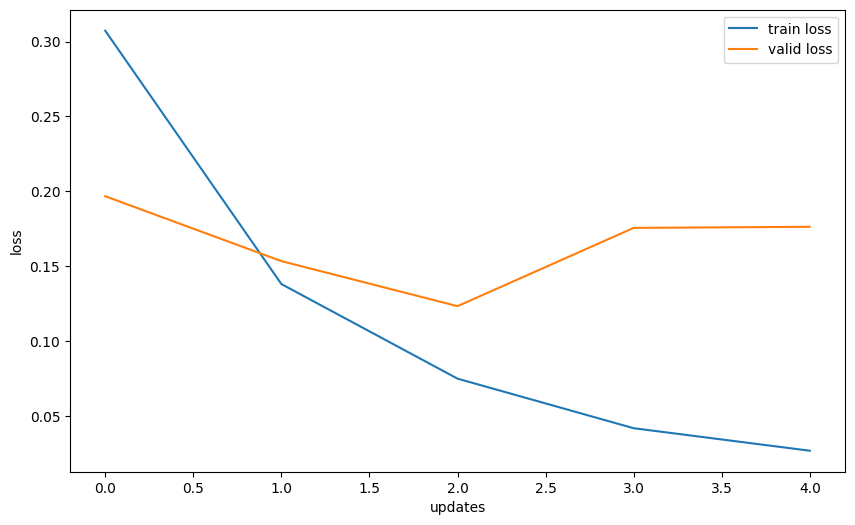

In [48]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(val_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

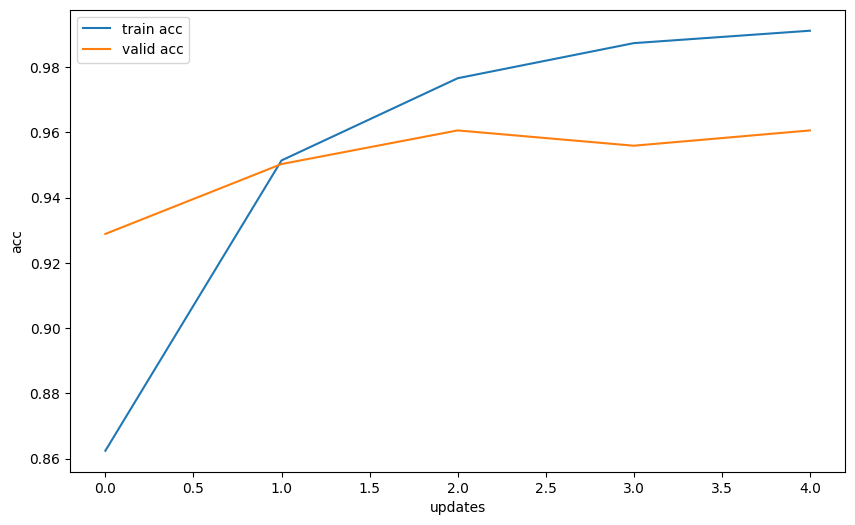

In [49]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(val_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

## Test model with test set

In [51]:
loaded_model = torch.load('biLSTM.pt')

In [52]:
with open('text_pipeline.pkl', 'rb') as f:
    loaded_text_pipeline = pickle.load(f)

In [53]:
test_loss, test_acc = evaluate(loaded_model, test_loader, criterion, test_loader_length)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.121 | Test Acc: 96.47%


## Test with unseen question

In [77]:
def predict(text_str):
    text_str = text_str.lower()
    regex_s = re.sub("\\(.+?\\)|[\r\n|\n\r]|!", "", text_str)
    text = " ".join(regex_s.split())
    text = torch.tensor(loaded_text_pipeline(text)).to(device)
    text = text.reshape(1, -1)
    text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)
    with torch.no_grad():
        output = model(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

In [78]:
text = "what is the best refrigerator on your store"
predict(text)

tensor([1])